# Get started script

This script shows how to 
- load fits images
- load architecture
- initialize architecture
- restore variables architecture from a file
- make a prediction

In [3]:
import tensorflow as tf
import numpy as np
from astropy.io import fits
import importlib.util
import matplotlib.pyplot as plt
%matplotlib inline

The ground based images of the challenge contains 4 bands 

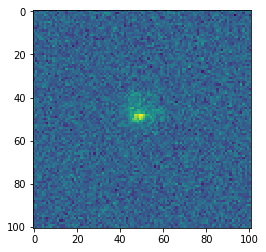

In [21]:
lens_band1 = fits.open('samples/ground_based/lens/Band1/imageSDSS_R-100002.fits')[0].data
lens_band2 = fits.open('samples/ground_based/lens/Band2/imageSDSS_I-100002.fits')[0].data
lens_band3 = fits.open('samples/ground_based/lens/Band3/imageSDSS_G-100002.fits')[0].data
lens_band4 = fits.open('samples/ground_based/lens/Band4/imageSDSS_U-100002.fits')[0].data
lens = np.stack([lens_band1, lens_band2, lens_band3, lens_band4], 2)

# show the green band
plt.imshow(lens[:,:,2])

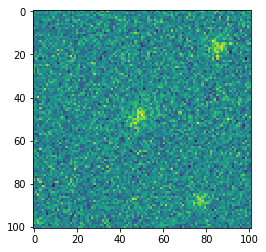

In [22]:
nolens_band1 = fits.open('samples/ground_based/nolens/Band1/imageSDSS_R-100004.fits')[0].data
nolens_band2 = fits.open('samples/ground_based/nolens/Band2/imageSDSS_I-100004.fits')[0].data
nolens_band3 = fits.open('samples/ground_based/nolens/Band3/imageSDSS_G-100004.fits')[0].data
nolens_band4 = fits.open('samples/ground_based/nolens/Band4/imageSDSS_U-100004.fits')[0].data
nolens = np.stack([nolens_band1, nolens_band2, nolens_band3, nolens_band4], 2)

# show the green band
plt.imshow(nolens[:,:,2])

Now let's create a neural network with the architecture defined in the file `arch_baseline.py`

In [4]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands)
    return g, nn

In [5]:
graph, nn = load_arch("arch_baseline.py", 4)

`graph` is an object from the tensorflow libraray that contain the graph of the NN (operation = verticies, tensors = edges)

The NN has been trained with images normalized with the statistics of the full dataset. The function `nn.prepare` simply subtract the mean and divide by the std. mean and std that has been computed on the full dataset.

In [39]:
images = nn.prepare(np.array([lens, nolens]))

In [40]:
sess = tf.Session(graph=graph)

Let make a prediction with the NN randomly initialized

In [33]:
sess.run(tf.variables_initializer(graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

In [34]:
nn.predict(sess, images)

array([ 0.00017993,  0.00031414], dtype=float32)

Now lets load the backup of a training from a backup file.

In [41]:
def load_backup(sess, graph, backup):
    with graph.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, backup)

In [42]:
load_backup(sess, graph, 'trained_variables/ground_based/baseline')

Now the prediction should give better results

In [43]:
nn.predict(sess, images)

array([  9.91008580e-01,   3.46407987e-40], dtype=float32)

If the normalisation is done only with the statistics of these two images it gives less good results

In [44]:
images = (images - images.mean()) / images.std()

In [45]:
nn.predict(sess, images)

array([ 0.44766834,  0.01100335], dtype=float32)